# GDELT News Data Extraction for GTA Area

## Download list of news files

### Environment:
 - Python: 3.5.5
 - gensim
 - conda install -c conda-forge newspaper3k
 - spacy
 - conda install -c conda-forge pyldavis
 - conda install -c conda-forge wordcloud

In [1]:
import warnings
warnings.filterwarnings('ignore')

import requests
import lxml.html as lh

gdelt_base_url = 'http://data.gdeltproject.org/events/'

# get the list of all the links on the gdelt file page
page = requests.get(gdelt_base_url+'index.html')
doc = lh.fromstring(page.content)
link_list = doc.xpath("//*/ul/li/a/@href")

# separate out those links that begin with four digits 
file_list = [x for x in link_list if str.isdigit(x[0:4])]

# preview the list
file_list[0:5]

['20190408.export.CSV.zip',
 '20190407.export.CSV.zip',
 '20190406.export.CSV.zip',
 '20190405.export.CSV.zip',
 '20190404.export.CSV.zip']

## Input Data

In [2]:
# geo-fence
lt1 = 43.403221
lt2 = 43.855401
lg1 = -79.639319
lg2 = -78.905820

# days back to process
days_back = 1

## Extract Relevant GDELT Rows

In [3]:
import os.path
import urllib
import zipfile
import glob
import operator

infilecounter = 0
outfilecounter = 0

dir_path = os.getcwd()
print ('Working dir: ' + dir_path)
                          
# make some dirs
local_path = dir_path + '\\'
if not os.path.exists(local_path+'data'):
    os.makedirs(local_path+'data')
if not os.path.exists(local_path+'gta-data'):
    os.makedirs(local_path+'gta-data')
    
for compressed_file in file_list[infilecounter:]:
    print ('data\\'+compressed_file),
    
    # if we dont have the compressed file stored locally, go get it. Keep trying if necessary.
    while not os.path.isfile(local_path+'data\\'+compressed_file): 
        print ('...downloading,'),
        urllib.request.urlretrieve(url=gdelt_base_url+compressed_file, 
                                   filename=local_path+'data\\'+compressed_file)
        
    # extract the contents of the compressed file to a temporary directory    
    print ('...extracting,'),
    z = zipfile.ZipFile(file=local_path + 'data\\' + compressed_file, mode='r')    
    z.extractall(path=local_path + 'tmp/')
    
    # parse each of the csv files in the working directory, 
    print ('...parsing,'),
    for infile_name in glob.glob(local_path + 'tmp/*'):
        outfile_name = local_path + 'gta-data\\' + 'gta' + '%04i.tsv'%outfilecounter    
    
        # open the infile and outfile
        with open(infile_name,  mode='r', encoding="utf8") as infile, \
             open(outfile_name, mode='w', encoding="utf8") as outfile:
            
            for line in infile:
                vals = line.split('\t')
                
                # extract geo-coordinates
                try:
                    lat  = float(vals[53]) # ActionGeo_Lat
                    long = float(vals[54]) # ActionGeo_Long
                except Exception as e:
                    # means no coordinates provided, skipping
                    continue
                
                # only use events inside geo-fence
                if  long >= lg1 and long <= lg2 and lat >= lt1 and lat <= lt2:
                    outfile.write(line)
                
            outfilecounter +=1
            
        # delete the temporary file
        os.remove(infile_name)
        
    infilecounter +=1
    if infilecounter >= days_back:
        print ('done')
        break

Working dir: C:\Users\ibaranov\Downloads\York\group-projects\CSDA1050-CAP\playground\GDELT2
data\20190408.export.CSV.zip
...extracting,
...parsing,
done


## Create dataframe with GDELT news info

In [4]:
import glob
import pandas as pd

# Get the GDELT field names from an external helper file
colnames = pd.read_excel('CSV.header.fieldids.xlsx', sheet_name='Sheet1', 
                         index_col='Column ID', usecols=1)['Field Name']

# Build DataFrames from each of the intermediary files
files = glob.glob(local_path+'gta-data/'+'*')
DFlist = []
for active_file in files:
    print (active_file)
    DFlist.append(pd.read_csv(active_file, sep='\t', header=None, dtype=str,
                              names=colnames, index_col=['GLOBALEVENTID']))

# Merge the file-based dataframes and serialize the dataframe
DF = pd.concat(DFlist)
DF.to_pickle(local_path+'backup'+'-gta'+'.pickle')    
    
# remove the temporary files
for active_file in files:
    os.remove(active_file)

C:\Users\ibaranov\Downloads\York\group-projects\CSDA1050-CAP\playground\GDELT2\gta-data\gta0000.tsv


## Show the captured data structure

In [5]:
list(DF)

['SQLDATE',
 'MonthYear',
 'Year',
 'FractionDate',
 'Actor1Code',
 'Actor1Name',
 'Actor1CountryCode',
 'Actor1KnownGroupCode',
 'Actor1EthnicCode',
 'Actor1Religion1Code',
 'Actor1Religion2Code',
 'Actor1Type1Code',
 'Actor1Type2Code',
 'Actor1Type3Code',
 'Actor2Code',
 'Actor2Name',
 'Actor2CountryCode',
 'Actor2KnownGroupCode',
 'Actor2EthnicCode',
 'Actor2Religion1Code',
 'Actor2Religion2Code',
 'Actor2Type1Code',
 'Actor2Type2Code',
 'Actor2Type3Code',
 'IsRootEvent',
 'EventCode',
 'EventBaseCode',
 'EventRootCode',
 'QuadClass',
 'GoldsteinScale',
 'NumMentions',
 'NumSources',
 'NumArticles',
 'AvgTone',
 'Actor1Geo_Type',
 'Actor1Geo_FullName',
 'Actor1Geo_CountryCode',
 'Actor1Geo_ADM1Code',
 'Actor1Geo_Lat',
 'Actor1Geo_Long',
 'Actor1Geo_FeatureID',
 'Actor2Geo_Type',
 'Actor2Geo_FullName',
 'Actor2Geo_CountryCode',
 'Actor2Geo_ADM1Code',
 'Actor2Geo_Lat',
 'Actor2Geo_Long',
 'Actor2Geo_FeatureID',
 'ActionGeo_Type',
 'ActionGeo_FullName',
 'ActionGeo_CountryCode',
 'Acti

## Preview one news article extracted text

In [6]:
from newspaper import Article

url = DF.iloc[129][-1]
print (url)
article = Article(url)
article.download()
article.parse()
article.text

https://obj.ca/index.php/article/cmhc-looks-raise-extra-money-housing-outside-billions-government


'The chief executive of the Canada Mortgage and Housing Corp. says his agency wants to raise hundreds of millions more dollars to help Canadians afford places to live, adding to the billions already available in government funding.\n\nEvan Siddall said the aim is to raise $100 million more for housing, quickly and likely from private sources, because the money pledged by federal and provincial governments over the next decade or so isn\'t enough to make housing affordable for everyone in the country.\n\nCMHC\'s corporate plan, released last month, set the ambitious goal of providing all Canadians with homes they can afford and meet their needs by 2030.\n\nAn estimated 1.6 million Canadian households are considered in "core housing need," meaning they live in places that are too expensive or aren\'t really suitable for them.\n\nSiddall admitted the goal is a moon-shot, but it\'s designed to force his agency and others to achieve more than is already eyed in the long-term national housin

## Text cleaning function

In [7]:
import spacy
from spacy.lang.en import English

parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

## Use NLTK’s Wordnet to find the meanings of words 

In [8]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ibaranov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Filter out stop words

In [9]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ibaranov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Function to prepare the text for topic modelling

In [10]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

## Check how the text data are converted

In [11]:
text_data = []
tokens = prepare_text_for_lda(article.text)
print(tokens)
text_data.append(tokens)

['chief', 'executive', 'canada', 'mortgage', 'housing', 'corp.', 'agency', 'want', 'raise', 'hundred', 'million', 'dollar', 'canadian', 'afford', 'place', 'add', 'billion', 'already', 'available', 'government', 'funding', 'siddall', 'raise', 'million', 'housing', 'quickly', 'likely', 'private', 'source', 'money', 'pledge', 'federal', 'provincial', 'government', 'decade', 'enough', 'housing', 'affordable', 'everyone', 'country', 'corporate', 'release', 'month', 'ambitious', 'provide', 'canadian', 'home', 'afford', 'need', 'estimate', 'million', 'canadian', 'household', 'consider', 'housing', 'meaning', 'place', 'expensive', 'really', 'suitable', 'siddall', 'admit', 'design', 'force', 'agency', 'others', 'achieve', 'already', 'national', 'housing', 'strategy', 'whose', 'price', 'billion', 'massive', 'investment', 'government', 'canada', 'investment', 'similarly', 'province', 'making', 'going', 'enough', 'siddall', 'telephone', 'interview', 'victoria', 'address', 'affordable', 'housing', 

## LDA with Gensim

In [12]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

## Serialize the dictionalry for future use

In [13]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

## LDA to find 5 topics in the data

In [14]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=8)
for topic in topics:
    print(topic)

(0, '0.006*"housing" + 0.006*"home" + 0.006*"mortgage" + 0.006*"government" + 0.006*"million" + 0.006*"federal" + 0.006*"agency" + 0.006*"developer"')
(1, '0.042*"housing" + 0.025*"mortgage" + 0.021*"home" + 0.018*"government" + 0.014*"share" + 0.014*"developer" + 0.014*"million" + 0.014*"siddall"')
(2, '0.006*"housing" + 0.006*"mortgage" + 0.006*"home" + 0.006*"federal" + 0.006*"siddall" + 0.006*"government" + 0.006*"share" + 0.006*"liberal"')
(3, '0.006*"housing" + 0.006*"mortgage" + 0.006*"home" + 0.006*"government" + 0.006*"developer" + 0.006*"share" + 0.006*"siddall" + 0.006*"federal"')
(4, '0.006*"housing" + 0.006*"mortgage" + 0.006*"government" + 0.006*"siddall" + 0.006*"home" + 0.006*"federal" + 0.006*"chief" + 0.006*"agency"')


## Visualizing topics with pyLDAvis

In [16]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## Sentiment analysis

In [19]:
from textblob import TextBlob

blob = TextBlob(article.text)
#print (blob)
blob.sentiment

Sentiment(polarity=0.1346626643796455, subjectivity=0.47124070897655784)

## Word Cloud

(-0.5, 399.5, 199.5, -0.5)

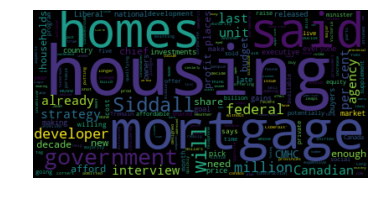

In [39]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(article.text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")